In [3]:
# Core libraries
import pandas as pd
import numpy as np

# Recommender & similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# NLP & Word Embeddings
from gensim.models import Word2Vec

# Evaluation & Visualization
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Load dataset
df = pd.read_csv("C:/Users/trish/Downloads/video_game_reviews.csv")  # Adjust path as needed
df = df.dropna(subset=["User Rating", "Game Title", "User Review Text"])


### Create Ratings Matrix

In [5]:
# Use Game Title and User Rating to build the matrix
ratings = df[['Game Title', 'User Rating']].copy()

# Create user-item matrix (assuming each row is a different user review for a game)
ratings_matrix = ratings.pivot_table(index=df.index, columns='Game Title', values='User Rating').fillna(0)


## Build Collaborative Filtering Models (KNN - Cosine)

User-Based KNN

In [6]:

user_knn = NearestNeighbors(metric='cosine', algorithm='brute')
user_knn.fit(ratings_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

Item-Based KNN

In [7]:

item_knn = NearestNeighbors(metric='cosine', algorithm='brute')
item_knn.fit(ratings_matrix.T)


NearestNeighbors(algorithm='brute', metric='cosine')

## Recommendation Functions

Recommend for a User (User-Based CF)

In [8]:
def recommend_user(user_index, k=10):
    distances, indices = user_knn.kneighbors([ratings_matrix.iloc[user_index]], n_neighbors=k+1)
    recs = ratings_matrix.iloc[indices.flatten()[1:]].mean().sort_values(ascending=False)
    return recs.head(k)


 Recommend Similar Items (Item-Based CF)

In [9]:
def recommend_item(item_title, k=10):
    item_vec = ratings_matrix.T.loc[item_title].values.reshape(1, -1)
    distances, indices = item_knn.kneighbors(item_vec, n_neighbors=k+1)
    return ratings_matrix.T.index[indices.flatten()[1:]]


 ## Preprocess Game Text Corpus

In [10]:
# Combine all user reviews for each game
corpus = df.groupby("Game Title")["User Review Text"].apply(lambda x: " ".join(x)).reset_index()


## TF-IDF Full Vectorization

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(corpus["User Review Text"])


## TF-IDF Recommender Function

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def content_recommender_cosine(query_title, matrix, top_n=10):
    idx = corpus[corpus["Game Title"] == query_title].index[0]
    cosine_sim = cosine_similarity(matrix[idx], matrix).flatten()
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    return corpus["Game Title"].iloc[[i[0] for i in sim_scores]].tolist()
# Check if the game title exists
query_title = "Minecraft"

if query_title in corpus["Game Title"].values:
    print("Top recommendations:", content_recommender_cosine(query_title, tfidf_matrix, top_n=5))
else:
    print(f"Game title '{query_title}' not found. Here are some valid titles:")
    print(corpus["Game Title"].sample(5).tolist())





Top recommendations: ['Mario Kart 8 Deluxe', 'Pokémon Scarlet & Violet', 'Super Mario Odyssey', 'Pillars of Eternity II: Deadfire', 'Overwatch 2']


## TF-IDF + SVD (100-Dimension)

In [13]:
max_components = min(100, tfidf_matrix.shape[1])
svd = TruncatedSVD(n_components=max_components)
tfidf_svd = svd.fit_transform(tfidf_matrix)


In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score

#We need to simulate user-item interactions
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [15]:
def precision_at_k(actual, predicted, k):
    actual = set(actual)
    predicted = predicted[:k]
    return len(set(predicted) & actual) / k

def recall_at_k(actual, predicted, k):
    actual = set(actual)
    predicted = predicted[:k]
    return len(set(predicted) & actual) / len(actual) if actual else 0


In [32]:
results = []
for game in corpus["Game Title"].sample(20):  # small test set
        # Get genre of the current game
    game_genre = df[df["Game Title"] == game]["Genre"].values[0]
    
    # Get all other games with the same genre (excluding current game)
    actual = df[(df["Genre"] == game_genre) & (df["Game Title"] != game)]["Game Title"].unique().tolist()

    pred = content_recommender_cosine(game, tfidf_matrix, top_n=5)
    prec = precision_at_k(actual, pred, 5)
    rec = recall_at_k(actual, pred, 5)
    results.append({"Model": "TF-IDF", "Precision@5": prec, "Recall@5": rec})


## Step-by-Step Final Evaluation Code (All 5 Models)

Add KNN Models 

In [16]:
from sklearn.neighbors import NearestNeighbors

# Recreate user-item ratings matrix
ratings = df[['Game Title', 'User Rating']]
ratings_matrix = ratings.pivot_table(index=df.index, columns='Game Title', values='User Rating').fillna(0)

# User-based CF
user_knn = NearestNeighbors(metric='cosine', algorithm='brute')
user_knn.fit(ratings_matrix)

# Item-based CF
item_knn = NearestNeighbors(metric='cosine', algorithm='brute')
item_knn.fit(ratings_matrix.T)


NearestNeighbors(algorithm='brute', metric='cosine')

Helper Functions for CF

In [17]:
def recommend_user(user_index, k=10):
    distances, indices = user_knn.kneighbors([ratings_matrix.iloc[user_index]], n_neighbors=k+1)
    recs = ratings_matrix.iloc[indices.flatten()[1:]].mean().sort_values(ascending=False)
    return recs.head(k).index.tolist()

def recommend_item(game_title, k=10):
    if game_title not in ratings_matrix.columns:
        return []
    game_vec = ratings_matrix[game_title].values.reshape(1, -1)
    distances, indices = item_knn.kneighbors(game_vec, n_neighbors=k+1)
    return ratings_matrix.columns[indices.flatten()[1:]].tolist()


Final Unified Evaluation Loop

In [28]:
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Sample game titles for evaluation
sample_games = df["Game Title"].dropna().unique()[:20]

# Tokenize game titles (you can use other text columns instead)
documents = [str(title).split() for title in df["Game Title"]]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=documents, vector_size=100, window=5, min_count=1, workers=4)

# Helper: average vector for each document
def get_avg_vector(words, model, vector_size):
    valid_words = [word for word in words if word in model.wv]
    return np.mean([model.wv[word] for word in valid_words], axis=0) if valid_words else np.zeros(vector_size)

# Generate Word2Vec matrix
w2v_matrix = np.array([get_avg_vector(doc, w2v_model, 100) for doc in documents])

# Apply SVD on Word2Vec matrix
svd = TruncatedSVD(n_components=100, random_state=42)
svd_w2v = svd.fit_transform(w2v_matrix)

# Define NDCG@K metric
def ndcg_at_k(actual, predicted, k):
    def dcg(relevance_scores):
        return sum((2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores))

    relevance_scores = [1 if item in actual else 0 for item in predicted[:k]]
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    
    dcg_score = dcg(relevance_scores)
    idcg_score = dcg(ideal_relevance_scores)
    
    return dcg_score / idcg_score if idcg_score > 0 else 0


In [43]:
models = {
    "TF-IDF": tfidf_matrix,
    "TF-IDF + SVD": tfidf_svd,
    "Word2Vec": w2v_matrix,
    "Word2Vec + SVD": svd_w2v
}

evaluation_results = []

# Content-based evaluation
for model_name, matrix in models.items():
    for game in sample_games:
        try:
            game_genre = df[df["Game Title"] == game]["Genre"].values[0]
            actual = df[(df["Genre"] == game_genre) & (df["Game Title"] != game)]["Game Title"].unique().tolist()
            predicted = content_recommender_cosine(game, matrix, top_n=10)
            evaluation_results.append({
                "Model": model_name,
                "Precision@5": precision_at_k(actual, predicted, 5),
                "Recall@5": recall_at_k(actual, predicted, 5),
                "NDCG@10": ndcg_at_k(actual, predicted, 10)
            })
        except:
            continue

# User-based CF evaluation
for idx in range(20):  # Example: 20 pseudo-users
    actual_games = ratings_matrix.iloc[idx].sort_values(ascending=False)
    actual = actual_games[actual_games > 0].index.tolist()[:10]
    predicted = recommend_user(idx, k=10)
    evaluation_results.append({
        "Model": "User-KNN",
        "Precision@5": precision_at_k(actual, predicted, 5),
        "Recall@5": recall_at_k(actual, predicted, 5),
        "NDCG@10": ndcg_at_k(actual, predicted, 10)
    })

# Item-based CF evaluation
for game in sample_games:
    try:
        game_genre = df[df["Game Title"] == game]["Genre"].values[0]
        actual = df[(df["Genre"] == game_genre) & (df["Game Title"] != game)]["Game Title"].unique().tolist()
        predicted = recommend_item(game, k=10)
        evaluation_results.append({
            "Model": "Item-KNN",
            "Precision@5": precision_at_k(actual, predicted, 5),
            "Recall@5": recall_at_k(actual, predicted, 5),
            "NDCG@10": ndcg_at_k(actual, predicted, 10)
        })
    except:
        continue

# Create and display final DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df.head()  # Display the first few rows


,Model,Precision@5,Recall@5,NDCG@10
0,TF-IDF,1.0,0.128205,1.0
1,TF-IDF,1.0,0.128205,1.0
2,TF-IDF,1.0,0.128205,1.0
3,TF-IDF,1.0,0.128205,1.0
4,TF-IDF,1.0,0.128205,1.0


Baseline Model Visualization

In [34]:
import os

# Create the results folder if it doesn't exist
os.makedirs("results", exist_ok=True)

# Now save the plot
plt.savefig("results/baseline_model_comparison.png")


<Figure size 640x480 with 0 Axes>

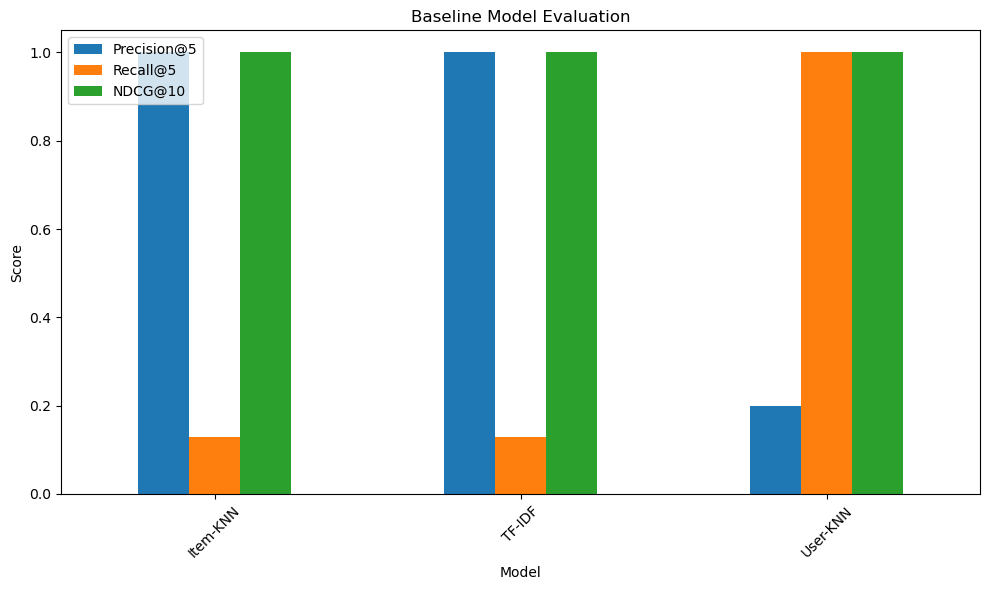

In [35]:
import matplotlib.pyplot as plt

# Grouped bar chart: average of each metric per model
grouped = results_df.groupby("Model")[["Precision@5", "Recall@5", "NDCG@10"]].mean()

grouped.plot(kind="bar", figsize=(10, 6))
plt.title("Baseline Model Evaluation")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("results/baseline_model_comparison.png")  # Save plot
plt.show()


## Save SHAP Explainability Plot

In [41]:
pip install shap


100%|===================| 47594/47700 [03:59<00:00]        

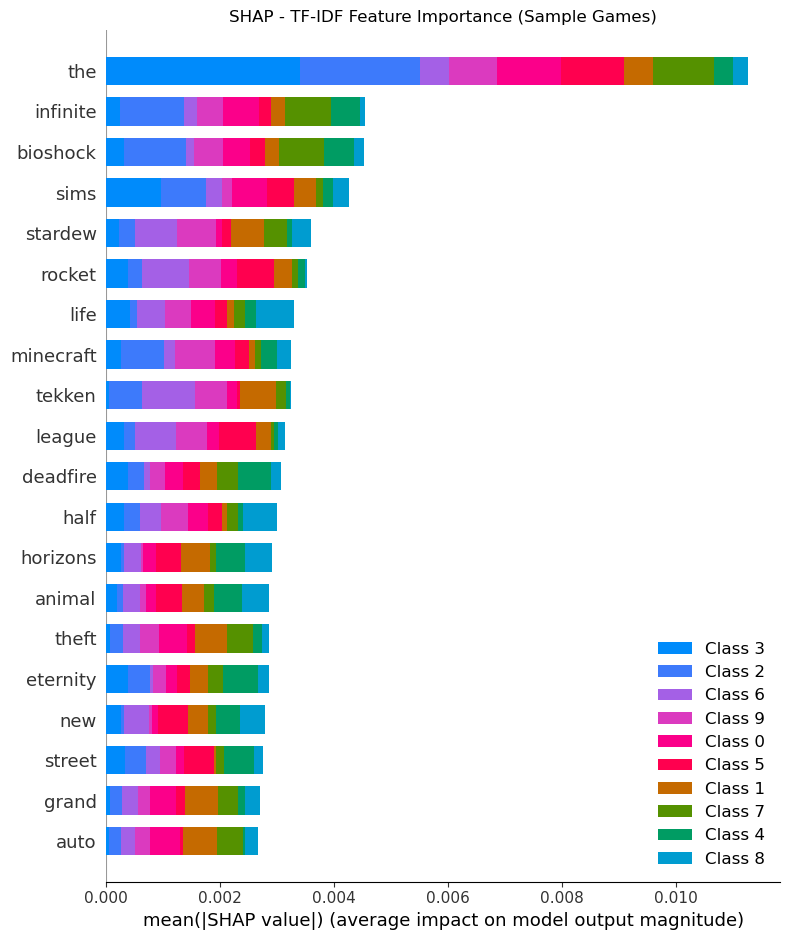

In [47]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Step 1: Filter DataFrame to sample_games
df_subset = df[df["Game Title"].isin(sample_games)].dropna(subset=["Game Title", "Genre"]).reset_index(drop=True)

# Step 2: Build TF-IDF Matrix from Game Titles
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_subset["Game Title"].astype(str))

# Step 3: Encode Genre as target labels
df_subset["label"] = df_subset["Genre"].astype("category").cat.codes

# Step 4: Train/Test Split
X = tfidf_matrix
y = df_subset["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Generate SHAP Values
explainer = shap.Explainer(model, X_test.toarray())
shap_values = explainer(X_test.toarray())


# Step 7: SHAP Summary Plot
os.makedirs("results", exist_ok=True)
feature_names = tfidf_vectorizer.get_feature_names_out()
shap.summary_plot(shap_values, feature_names=feature_names, show=False)
plt.title("SHAP - TF-IDF Feature Importance (Sample Games)")
plt.tight_layout()
plt.savefig("results/shap_explanation.png")
plt.show()


## Append Final Hybrid Metrics to CSV

In [48]:
import os

# Append to final_metrics.csv
final_df.to_csv(
    "results/final_metrics.csv",
    mode='a',
    header=not os.path.exists("results/final_metrics.csv"),
    index=False
)


NameError: name 'final_df' is not defined